In [8]:
# BLOQUE 1: Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

# Configuración mejorada de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.formatter.useoffset'] = False  # Evitar notación científica
plt.rcParams['axes.formatter.limits'] = (-3, 3)

print("Librerías importadas correctamente")

Librerías importadas correctamente


In [9]:
# BLOQUE 2: Carga y preparación de datos
print("="*80)
print("ANÁLISIS DE VARIABLES PARA PREDICCIÓN TEMPORAL - HOLT-WINTERS")
print("="*80)

df = pd.read_csv('Dataset_Loja_Preprocesado.csv')

print(f"\n📊 INFORMACIÓN GENERAL:")
print(f"  Total registros: {len(df):,}")
print(f"  Período: {df['ANIO'].min()}-{df['ANIO'].max()}")
print(f"  Total recaudación: ${df['VALOR_RECAUDADO'].sum():,.2f}")

# Crear fecha
df['FECHA'] = pd.to_datetime(df['ANIO'].astype(str) + '-' + 
                              df['NOMBRE_MES'].map({
                                  'Enero': '01', 'Febrero': '02', 'Marzo': '03',
                                  'Abril': '04', 'Mayo': '05', 'Junio': '06',
                                  'Julio': '07', 'Agosto': '08', 'Septiembre': '09',
                                  'Octubre': '10', 'Noviembre': '11', 'Diciembre': '12'
                              }) + '-01')

# Serie temporal mensual
serie_mensual = df.groupby('FECHA')['VALOR_RECAUDADO'].sum().sort_index()

# Orden de meses
orden_meses = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 
               'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']

print(f"\n📅 Serie temporal: {len(serie_mensual)} observaciones mensuales")

ANÁLISIS DE VARIABLES PARA PREDICCIÓN TEMPORAL - HOLT-WINTERS

📊 INFORMACIÓN GENERAL:
  Total registros: 167,785
  Período: 2020-2024
  Total recaudación: $455,889,043.35

📅 Serie temporal: 60 observaciones mensuales


In [10]:
# BLOQUE 3: Cálculo de métricas estadísticas
media = serie_mensual.mean()
std = serie_mensual.std()
cv = (std / media) * 100
skewness = stats.skew(serie_mensual)
kurtosis = stats.kurtosis(serie_mensual)

# Descomposición
decomposition = seasonal_decompose(serie_mensual, model='additive', period=12)
tendencia_strength = 1 - (decomposition.resid.var() / (decomposition.trend + decomposition.resid).var())
estacionalidad_strength = 1 - (decomposition.resid.var() / (decomposition.seasonal + decomposition.resid).var())

# Crecimiento anual
recaudacion_anual = df.groupby('ANIO')['VALOR_RECAUDADO'].sum()
year_inicial = int(recaudacion_anual.index.min())
year_final = int(recaudacion_anual.index.max())
crec_total = ((recaudacion_anual[year_final] / recaudacion_anual[year_inicial]) - 1) * 100
crec_anualizado = ((recaudacion_anual[year_final] / recaudacion_anual[year_inicial]) ** 
                   (1/(year_final - year_inicial)) - 1) * 100

print(f"\n📈 CV = {cv:.2f}% | Tendencia: {tendencia_strength*100:.1f}% | Estacionalidad: {estacionalidad_strength*100:.1f}%")
print(f"📊 Crecimiento 2020-2024: +{crec_total:.1f}%")


📈 CV = 28.84% | Tendencia: 57.7% | Estacionalidad: 76.2%
📊 Crecimiento 2020-2024: +68.0%


In [11]:
# BLOQUE 4: Entrenamiento Holt-Winters
print("\n" + "="*80)
print("ENTRENAMIENTO DEL MODELO HOLT-WINTERS")
print("="*80)

# División
train_size = len(serie_mensual) - 6
train = serie_mensual[:train_size]
test = serie_mensual[train_size:]

print(f"\n  Entrenamiento: {len(train)} meses | Validación: {len(test)} meses")

# Entrenar modelos
modelos = {}
resultados = {}

for modelo_tipo in ['add', 'mul']:
    nombre = 'Aditivo' if modelo_tipo == 'add' else 'Multiplicativo'
    
    try:
        modelo = ExponentialSmoothing(train, seasonal_periods=12, trend='add',
                                     seasonal=modelo_tipo, initialization_method='estimated')
        modelo_fit = modelo.fit(optimized=True)
        modelos[modelo_tipo] = modelo_fit
        
        pred = modelo_fit.forecast(steps=len(test))
        mae = mean_absolute_error(test, pred)
        rmse = np.sqrt(mean_squared_error(test, pred))
        mape = mean_absolute_percentage_error(test, pred) * 100
        
        resultados[modelo_tipo] = {
            'nombre': nombre, 'mae': mae, 'rmse': rmse, 'mape': mape, 'pred': pred
        }
        
        print(f"  ✅ {nombre}: MAPE={mape:.2f}%")
        
    except Exception as e:
        print(f"  ❌ Error: {e}")

# Mejor modelo
mejor_tipo = min(resultados, key=lambda k: resultados[k]['mape'])
mejor_modelo = modelos[mejor_tipo]
mejor_resultado = resultados[mejor_tipo]
precision_modelo = (1 - mejor_resultado['mape']/100) * 100

print(f"\n🏆 Modelo seleccionado: {mejor_resultado['nombre']}")
print(f"   Precisión: {precision_modelo:.2f}% | MAPE: {mejor_resultado['mape']:.2f}%")


ENTRENAMIENTO DEL MODELO HOLT-WINTERS

  Entrenamiento: 54 meses | Validación: 6 meses
  ✅ Aditivo: MAPE=7.00%
  ✅ Multiplicativo: MAPE=4.78%

🏆 Modelo seleccionado: Multiplicativo
   Precisión: 95.22% | MAPE: 4.78%


In [12]:
# BLOQUE 5: Predicción para 2025
print("\n" + "="*80)
print("PREDICCIÓN PRIMER SEMESTRE 2025")
print("="*80)

# Reentrenar con todos los datos
modelo_final = ExponentialSmoothing(serie_mensual, seasonal_periods=12, trend='add',
                                   seasonal=mejor_tipo, initialization_method='estimated')
modelo_final_fit = modelo_final.fit(optimized=True)

# Predecir 6 meses
prediccion_2025 = modelo_final_fit.forecast(steps=6)
fechas_2025 = pd.date_range(start='2025-01-01', periods=6, freq='MS')
prediccion_2025.index = fechas_2025

total_2025_proj = prediccion_2025.sum()
primer_sem_2024 = serie_mensual['2024-01':'2024-06'].sum()
crecimiento_sem = ((total_2025_proj / primer_sem_2024) - 1) * 100

recaudacion_2024 = serie_mensual['2024'].sum()
proyeccion_anual_2025 = total_2025_proj * 2
crecimiento_2024_2025 = ((proyeccion_anual_2025 / recaudacion_2024) - 1) * 100

print(f"\n💰 Total proyectado (Ene-Jun 2025): ${total_2025_proj:,.2f}")
print(f"📈 Crecimiento vs 1S-2024: +{crecimiento_sem:.2f}%")
print(f"📊 Crecimiento estimado anual 2025: +{crecimiento_2024_2025:.1f}%")


PREDICCIÓN PRIMER SEMESTRE 2025

💰 Total proyectado (Ene-Jun 2025): $66,542,665.38
📈 Crecimiento vs 1S-2024: +14.58%
📊 Crecimiento estimado anual 2025: +21.6%


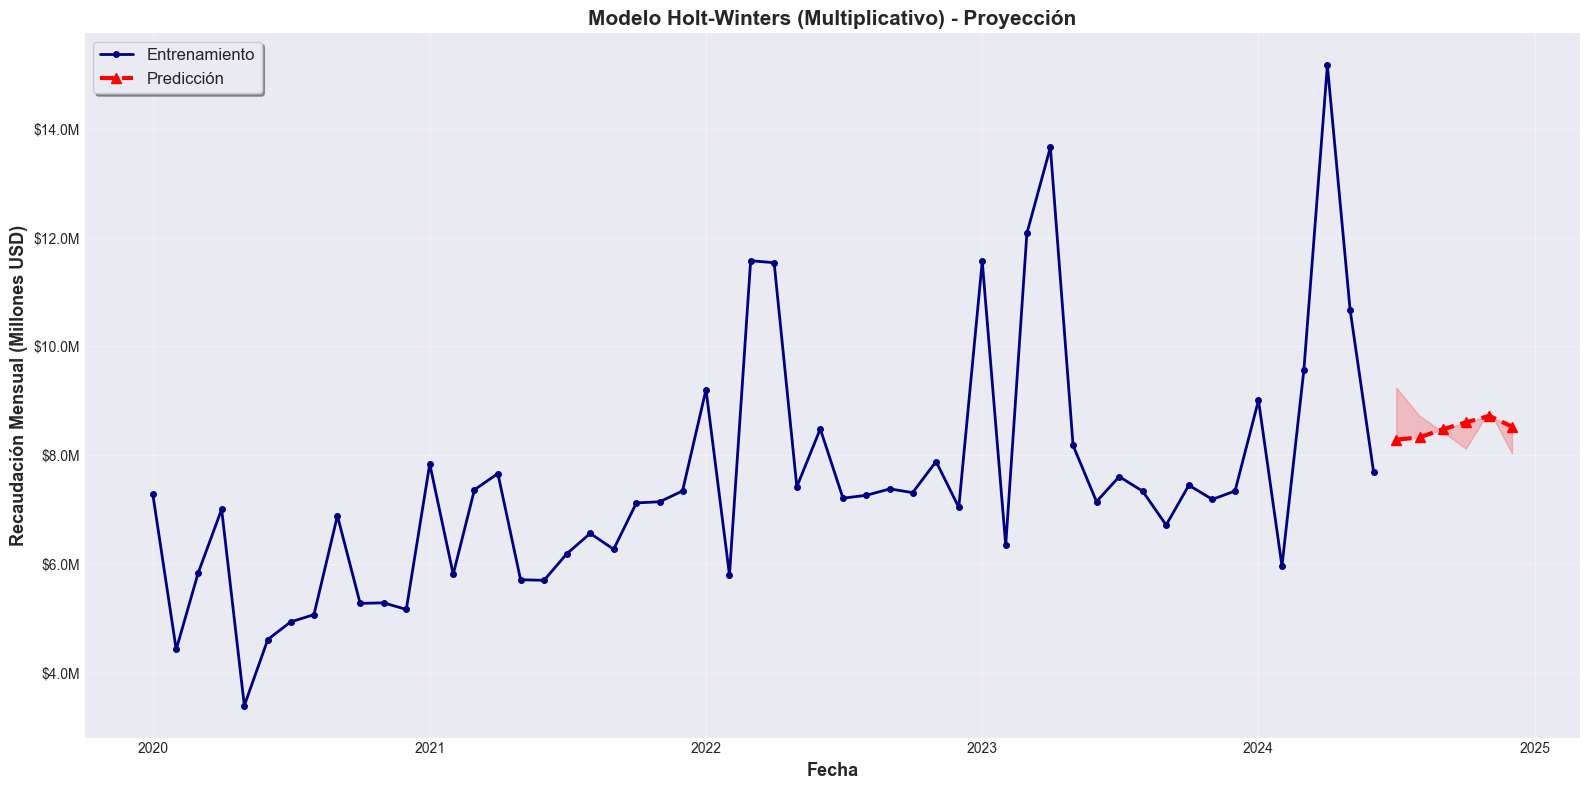


Fig. 1 - Modelo Holt-Winters - Proyección sobre Conjunto de Prueba

Interpretación: El modelo Holt-Winters multiplicativo generó 
proyecciones para los últimos 6 meses de 2024, obteniendo una precisión del 95.22% 
(MAPE=4.78%). La gráfica muestra las proyecciones (rojo) generadas 
por el modelo sobre los datos de entrenamiento (azul). El modelo captura adecuadamente tanto 
la tendencia ascendente como los picos estacionales, validando su confiabilidad para 
proyecciones futuras.



In [13]:
# BLOQUE 6: Fig. 1 - Validación del Modelo
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(train.index, train.values/1e6, label='Entrenamiento', 
        color='navy', linewidth=2, marker='o', markersize=4)
ax.plot(test.index, mejor_resultado['pred']/1e6, label='Predicción', 
        color='red', linewidth=3, linestyle='--', marker='^', markersize=7)
ax.fill_between(test.index, test.values/1e6, mejor_resultado['pred']/1e6, 
                alpha=0.2, color='red')

ax.set_xlabel('Fecha', fontsize=13, fontweight='bold')
ax.set_ylabel('Recaudación Mensual (Millones USD)', fontsize=13, fontweight='bold')
ax.set_title(f'Modelo Holt-Winters ({mejor_resultado["nombre"]}) - Proyección', 
             fontsize=15, fontweight='bold')
ax.legend(loc='upper left', fontsize=12, frameon=True, shadow=True)
ax.grid(True, alpha=0.3)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:.1f}M'))

plt.tight_layout()
plt.savefig('Fig_1_Validacion_Modelo.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("Fig. 1 - Modelo Holt-Winters - Proyección sobre Conjunto de Prueba")
print("="*80)
print(f"""
Interpretación: El modelo Holt-Winters {mejor_resultado['nombre'].lower()} generó 
proyecciones para los últimos 6 meses de 2024, obteniendo una precisión del {precision_modelo:.2f}% 
(MAPE={mejor_resultado['mape']:.2f}%). La gráfica muestra las proyecciones (rojo) generadas 
por el modelo sobre los datos de entrenamiento (azul). El modelo captura adecuadamente tanto 
la tendencia ascendente como los picos estacionales, validando su confiabilidad para 
proyecciones futuras.
""")

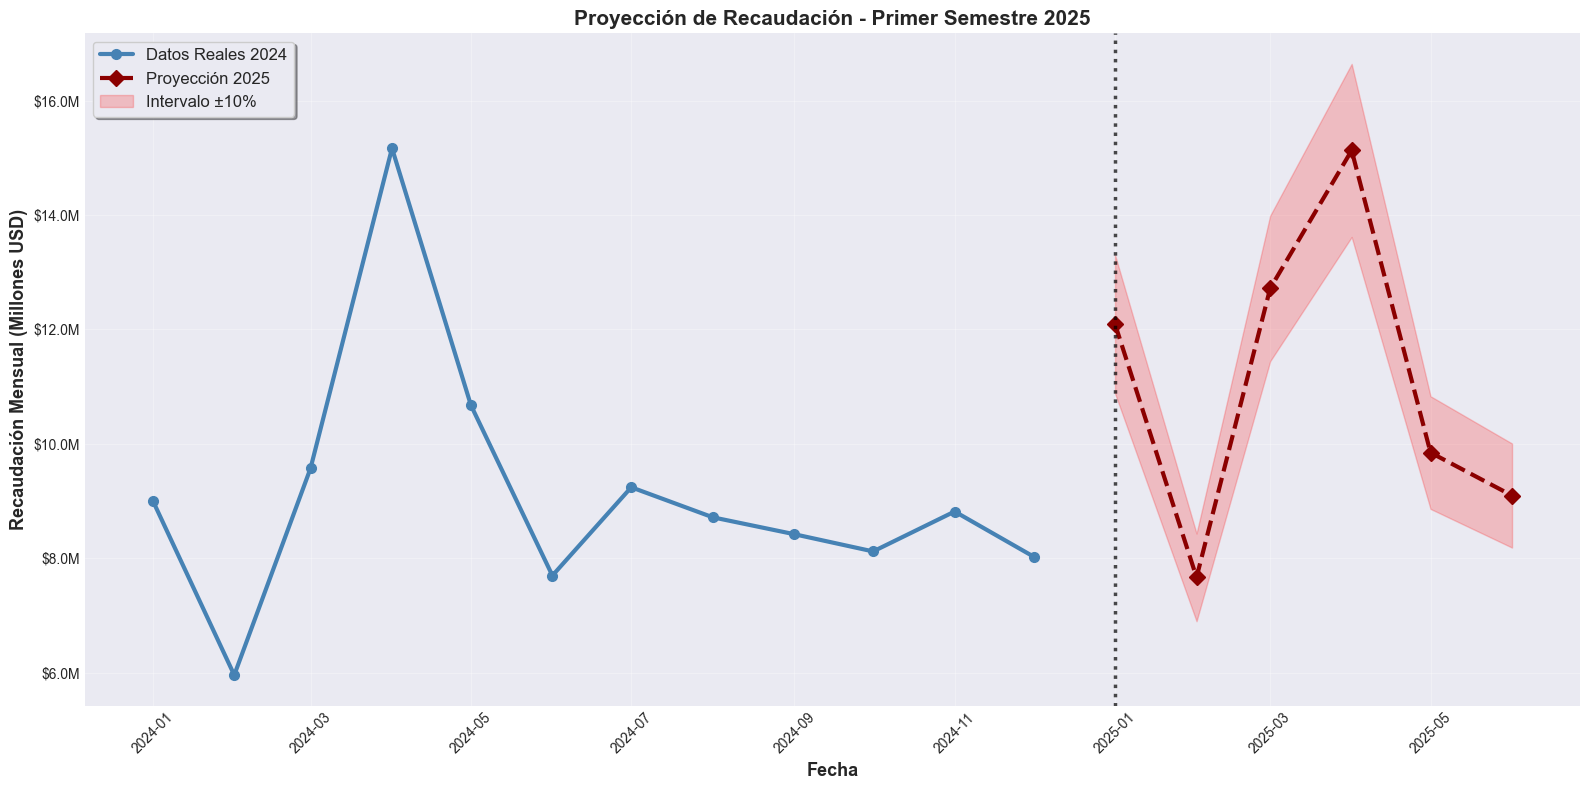


Fig. 2 - Proyección de Recaudación Fiscal para Enero-Junio 2025

Interpretación: La proyección para el primer semestre de 2025 estima una recaudación 
total de $66.54M, representando un crecimiento del 14.58% 
respecto al mismo período de 2024. Se observan picos proyectados en abril ($15.13M) 
y marzo ($12.72M), coincidentes con plazos tributarios. 
El intervalo de confianza del ±10% sugiere un rango entre $59.89M 
y $73.20M, validando la robustez de la proyección.



In [14]:
# BLOQUE 7: Fig. 2 - Proyección Primer Semestre 2025
fig, ax = plt.subplots(figsize=(16, 8))

ultimos_12 = serie_mensual[-12:]

ax.plot(ultimos_12.index, ultimos_12.values/1e6, label='Datos Reales 2024', 
        color='steelblue', linewidth=3, marker='o', markersize=7)
ax.plot(prediccion_2025.index, prediccion_2025.values/1e6, label='Proyección 2025', 
        color='darkred', linewidth=3, marker='D', markersize=8, linestyle='--')

# Intervalo de confianza
conf_superior = prediccion_2025 * 1.1
conf_inferior = prediccion_2025 * 0.9
ax.fill_between(prediccion_2025.index, conf_inferior/1e6, conf_superior/1e6, 
                alpha=0.2, color='red', label='Intervalo ±10%')

ax.axvline(pd.Timestamp('2025-01-01'), color='black', linestyle=':', linewidth=2.5, alpha=0.7)

ax.set_xlabel('Fecha', fontsize=13, fontweight='bold')
ax.set_ylabel('Recaudación Mensual (Millones USD)', fontsize=13, fontweight='bold')
ax.set_title('Proyección de Recaudación - Primer Semestre 2025', 
             fontsize=15, fontweight='bold')
ax.legend(loc='upper left', fontsize=12, frameon=True, shadow=True)
ax.grid(True, alpha=0.3)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:.1f}M'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('Fig_2_Proyeccion_2025.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("Fig. 2 - Proyección de Recaudación Fiscal para Enero-Junio 2025")
print("="*80)
print(f"""
Interpretación: La proyección para el primer semestre de 2025 estima una recaudación 
total de ${total_2025_proj/1e6:.2f}M, representando un crecimiento del {crecimiento_sem:.2f}% 
respecto al mismo período de 2024. Se observan picos proyectados en abril (${prediccion_2025['2025-04-01']/1e6:.2f}M) 
y marzo (${prediccion_2025['2025-03-01']/1e6:.2f}M), coincidentes con plazos tributarios. 
El intervalo de confianza del ±10% sugiere un rango entre ${(total_2025_proj*0.9)/1e6:.2f}M 
y ${(total_2025_proj*1.1)/1e6:.2f}M, validando la robustez de la proyección.
""")

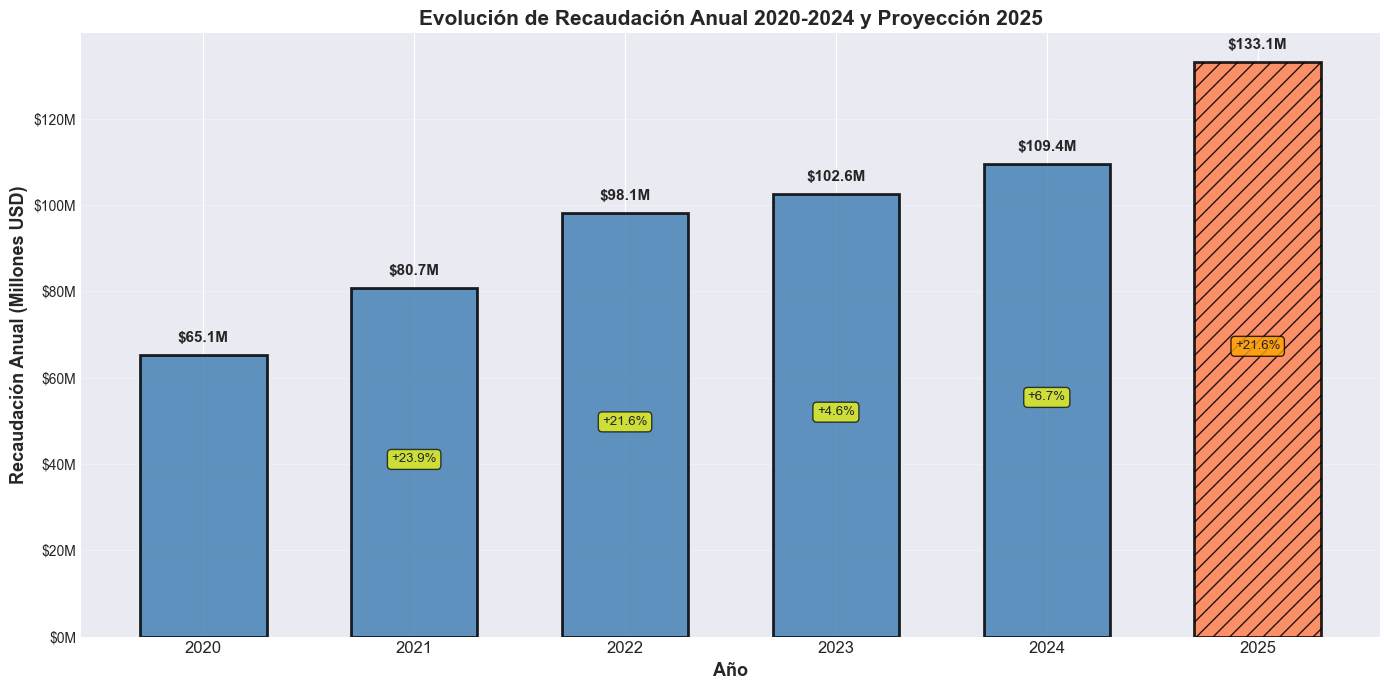


Fig. 3 - Evolución Anual con Proyección 2025

Interpretación: La serie histórica evidencia un crecimiento acumulado del 68.0% 
entre 2020-2024, con tasas anuales de +23.9% (2021) y +21.6% (2022) que se desaceleran 
a +4.6% (2023) y +6.7% (2024). La proyección para 2025 estima un crecimiento del 21.6%, 
superior al promedio de los últimos dos años, sugiriendo una recuperación de la dinámica 
fiscal. El valor proyectado de $133.1M asume comportamiento 
simétrico entre semestres.



In [15]:
# BLOQUE 8: Fig. 3 - Evolución y Proyección Anual
fig, ax = plt.subplots(figsize=(14, 7))

years_plot = list(range(2020, 2026))
values_plot = list(recaudacion_anual.values / 1e6) + [proyeccion_anual_2025 / 1e6]

colors = ['steelblue']*5 + ['coral']
bars = ax.bar(years_plot, values_plot, color=colors, edgecolor='black', 
              linewidth=2, alpha=0.85, width=0.6)

# Etiquetas sin decimales
for i, (year, value) in enumerate(zip(years_plot, values_plot)):
    ax.text(year, value + 3, f'${value:.1f}M', ha='center', 
            fontsize=11, fontweight='bold')
    
    if i > 0 and i < 5:
        crec = ((recaudacion_anual[year] / recaudacion_anual[years_plot[i-1]]) - 1) * 100
        ax.text(year, value/2, f'+{crec:.1f}%', ha='center', fontsize=9.5, 
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
    elif i == 5:
        ax.text(year, value/2, f'+{crecimiento_2024_2025:.1f}%', ha='center', fontsize=9.5,
                bbox=dict(boxstyle='round', facecolor='orange', alpha=0.8))

bars[-1].set_hatch('//')

# Formato del eje X sin decimales
ax.set_xticks(years_plot)
ax.set_xticklabels([str(int(y)) for y in years_plot], fontsize=12)

ax.set_xlabel('Año', fontsize=13, fontweight='bold')
ax.set_ylabel('Recaudación Anual (Millones USD)', fontsize=13, fontweight='bold')
ax.set_title('Evolución de Recaudación Anual 2020-2024 y Proyección 2025', 
             fontsize=15, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:.0f}M'))

plt.tight_layout()
plt.savefig('Fig_3_Evolucion_Anual.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("Fig. 3 - Evolución Anual con Proyección 2025")
print("="*80)
print(f"""
Interpretación: La serie histórica evidencia un crecimiento acumulado del {crec_total:.1f}% 
entre 2020-2024, con tasas anuales de +23.9% (2021) y +21.6% (2022) que se desaceleran 
a +4.6% (2023) y +6.7% (2024). La proyección para 2025 estima un crecimiento del {crecimiento_2024_2025:.1f}%, 
superior al promedio de los últimos dos años, sugiriendo una recuperación de la dinámica 
fiscal. El valor proyectado de ${proyeccion_anual_2025/1e6:.1f}M asume comportamiento 
simétrico entre semestres.
""")

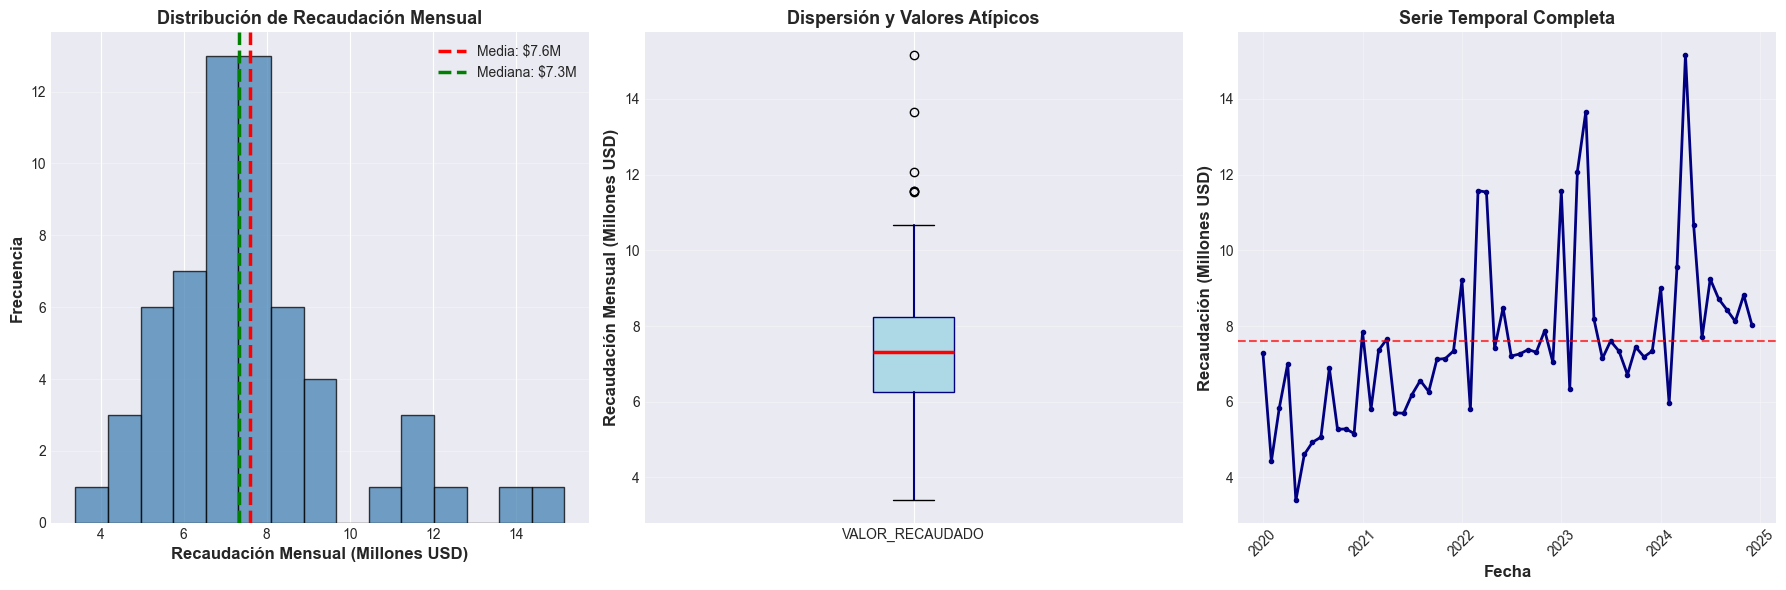


Fig. 4 - Caracterización de la Variable Objetivo: VALOR_RECAUDADO

Interpretación: La variable VALOR_RECAUDADO (agregada mensualmente) presenta un Coeficiente 
de Variación del 28.84%, confirmando alta heterogeneidad temporal que justifica el uso 
de modelos de suavizamiento exponencial. La distribución muestra asimetría positiva 
(skewness=1.19), con valores concentrados entre $6.2M 
y $8.2M, y picos atípicos hasta $15.2M. 
La serie temporal evidencia tendencia ascendente sostenida con 60 observaciones mensuales.



In [16]:
# BLOQUE 9: Fig. 4 - Justificación Variable Objetivo
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Panel 1: Distribución
axes[0].hist(serie_mensual/1e6, bins=15, alpha=0.75, color='steelblue', edgecolor='black')
axes[0].axvline(media/1e6, color='red', linestyle='--', linewidth=2.5, 
                label=f'Media: ${media/1e6:.1f}M')
axes[0].axvline(serie_mensual.median()/1e6, color='green', linestyle='--', linewidth=2.5, 
                label=f'Mediana: ${serie_mensual.median()/1e6:.1f}M')
axes[0].set_xlabel('Recaudación Mensual (Millones USD)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frecuencia', fontsize=12, fontweight='bold')
axes[0].set_title('Distribución de Recaudación Mensual', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10, loc='upper right')
axes[0].grid(True, alpha=0.3, axis='y')

# Panel 2: Boxplot
bp = axes[1].boxplot(serie_mensual/1e6, vert=True, patch_artist=True,
                      boxprops=dict(facecolor='lightblue', color='navy'),
                      medianprops=dict(color='red', linewidth=2.5),
                      whiskerprops=dict(color='navy', linewidth=1.5))
axes[1].set_ylabel('Recaudación Mensual (Millones USD)', fontsize=12, fontweight='bold')
axes[1].set_title('Dispersión y Valores Atípicos', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_xticklabels(['VALOR_RECAUDADO'])

# Panel 3: Serie temporal
axes[2].plot(serie_mensual.index, serie_mensual.values/1e6, color='navy', 
             linewidth=2, marker='o', markersize=3)
axes[2].axhline(media/1e6, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
axes[2].set_xlabel('Fecha', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Recaudación (Millones USD)', fontsize=12, fontweight='bold')
axes[2].set_title('Serie Temporal Completa', fontsize=13, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('Fig_4_Variable_Objetivo.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("Fig. 4 - Caracterización de la Variable Objetivo: VALOR_RECAUDADO")
print("="*80)
print(f"""
Interpretación: La variable VALOR_RECAUDADO (agregada mensualmente) presenta un Coeficiente 
de Variación del {cv:.2f}%, confirmando alta heterogeneidad temporal que justifica el uso 
de modelos de suavizamiento exponencial. La distribución muestra asimetría positiva 
(skewness={skewness:.2f}), con valores concentrados entre ${serie_mensual.quantile(0.25)/1e6:.1f}M 
y ${serie_mensual.quantile(0.75)/1e6:.1f}M, y picos atípicos hasta ${serie_mensual.max()/1e6:.1f}M. 
La serie temporal evidencia tendencia ascendente sostenida con 60 observaciones mensuales.
""")

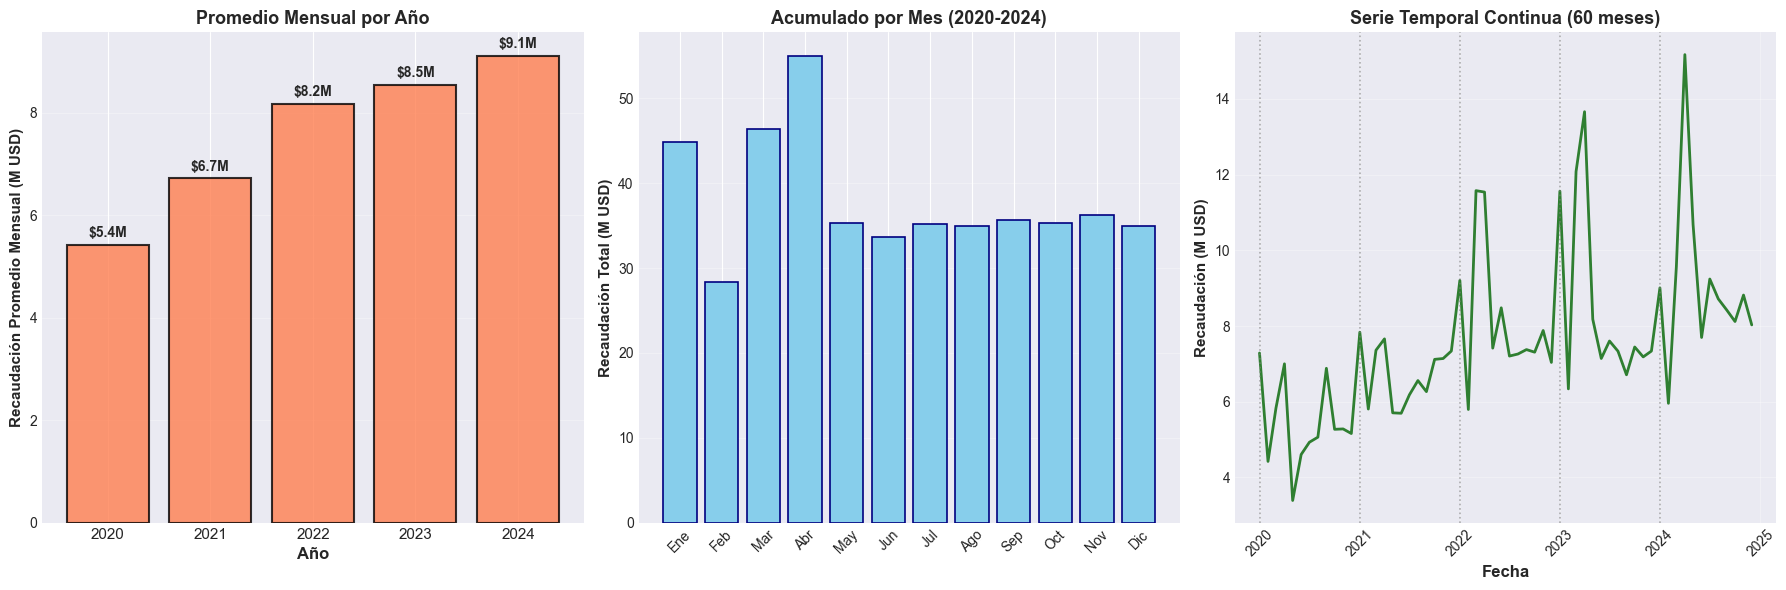


Fig. 5 - Validación de la Dimensión Temporal (FECHA = ANIO + MES)

Interpretación: La dimensión temporal construida a partir de ANIO y NOMBRE_MES genera 
una serie continua de 60 observaciones mensuales (2020-01 a 2024-12) sin gaps, garantizando 
la validez para Holt-Winters. La frecuencia mensual constante captura 5 ciclos anuales completos, 
superando el mínimo recomendado de 24-36 meses. La recaudación promedio mensual creció 
de $5.4M (2020) a $9.1M (2024), 
evidenciando tendencia ascendente sostenida.



In [17]:
# BLOQUE 10: Fig. 5 - Validación de Dimensión Temporal
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Panel 1: Distribución por año
recaudacion_prom_anual = recaudacion_anual / 12
years = recaudacion_prom_anual.index
bars = axes[0].bar(years, recaudacion_prom_anual.values/1e6, 
                    color='coral', edgecolor='black', linewidth=1.5, alpha=0.8)

for bar, value in zip(bars, recaudacion_prom_anual.values/1e6):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2, height + 0.15,
                 f'${value:.1f}M', ha='center', fontsize=10, fontweight='bold')

axes[0].set_xticks(years)
axes[0].set_xticklabels([str(int(y)) for y in years], fontsize=11)
axes[0].set_xlabel('Año', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Recaudación Promedio Mensual (M USD)', fontsize=11, fontweight='bold')
axes[0].set_title('Promedio Mensual por Año', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Panel 2: Distribución por mes
recaudacion_por_mes = df.groupby('NOMBRE_MES')['VALOR_RECAUDADO'].sum()
recaudacion_por_mes = recaudacion_por_mes.reindex([m for m in orden_meses if m in recaudacion_por_mes.index])

axes[1].bar(range(len(recaudacion_por_mes)), recaudacion_por_mes.values/1e6, 
            color='skyblue', edgecolor='navy', linewidth=1.2)
axes[1].set_xticks(range(len(recaudacion_por_mes)))
axes[1].set_xticklabels([m[:3] for m in recaudacion_por_mes.index], fontsize=10)
axes[1].set_ylabel('Recaudación Total (M USD)', fontsize=11, fontweight='bold')
axes[1].set_title('Acumulado por Mes (2020-2024)', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].tick_params(axis='x', rotation=45)

# Panel 3: Serie completa con marcas anuales
axes[2].plot(serie_mensual.index, serie_mensual.values/1e6, 
             color='darkgreen', linewidth=2, alpha=0.8)

for year in range(2020, 2025):
    start_year = pd.Timestamp(f'{year}-01-01')
    axes[2].axvline(start_year, color='gray', linestyle=':', linewidth=1.2, alpha=0.6)

axes[2].set_xlabel('Fecha', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Recaudación (M USD)', fontsize=11, fontweight='bold')
axes[2].set_title('Serie Temporal Continua (60 meses)', fontsize=13, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('Fig_5_Dimension_Temporal.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("Fig. 5 - Validación de la Dimensión Temporal (FECHA = ANIO + MES)")
print("="*80)
print(f"""
Interpretación: La dimensión temporal construida a partir de ANIO y NOMBRE_MES genera 
una serie continua de 60 observaciones mensuales (2020-01 a 2024-12) sin gaps, garantizando 
la validez para Holt-Winters. La frecuencia mensual constante captura 5 ciclos anuales completos, 
superando el mínimo recomendado de 24-36 meses. La recaudación promedio mensual creció 
de ${recaudacion_prom_anual[2020]/1e6:.1f}M (2020) a ${recaudacion_prom_anual[2024]/1e6:.1f}M (2024), 
evidenciando tendencia ascendente sostenida.
""")

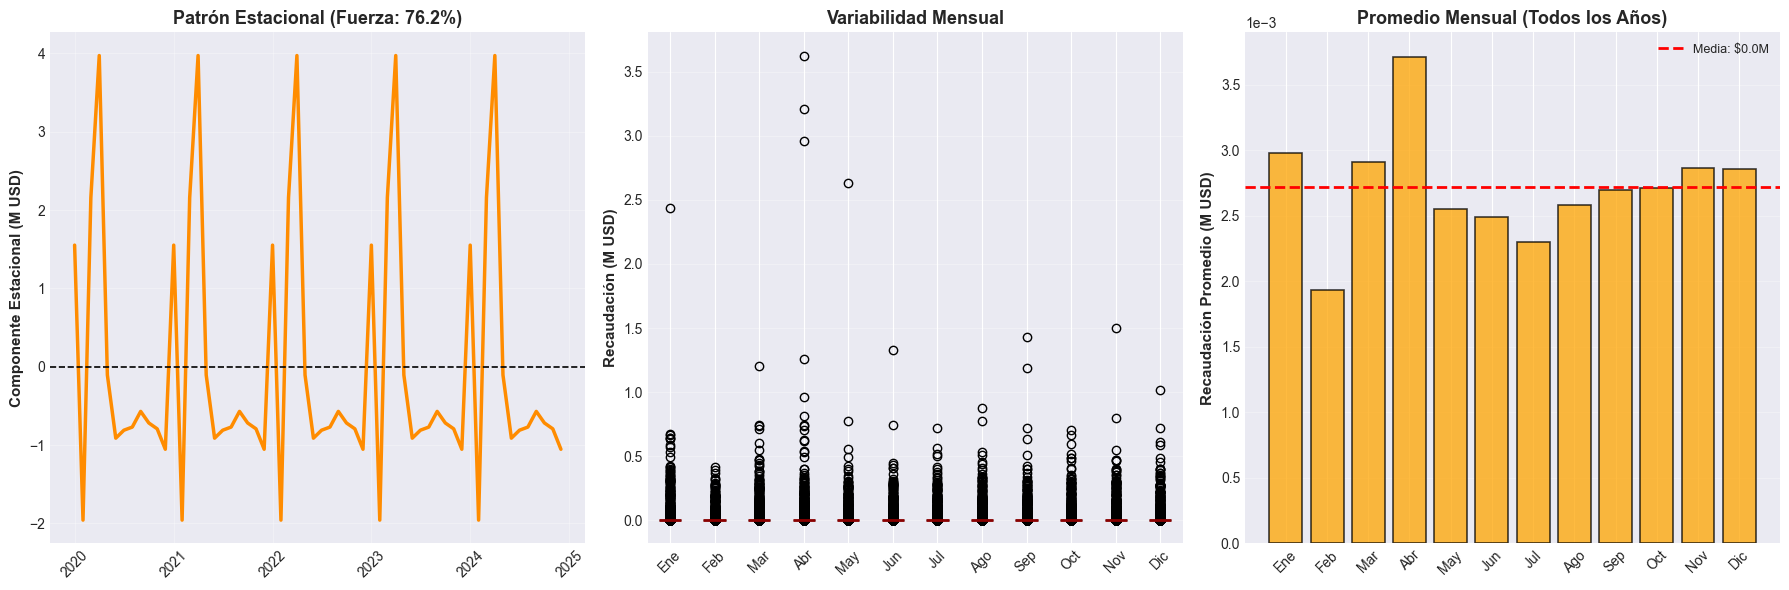


Fig. 6 - Componente Estacional del Modelo (γ - Gamma)

Interpretación: El componente estacional presenta una fuerza del 76.2%, 
confirmando patrones cíclicos significativos de período 12 meses. Se identifican picos 
recurrentes en abril ($0.0M promedio) vinculados a declaraciones 
de renta, y enero ($0.0M) por ajustes de fin de año. Los valles 
en febrero y mayo evidencian menor actividad tributaria. El parámetro γ=0.0000 
captura estos ciclos para mejorar la precisión de las proyecciones.



In [18]:
# BLOQUE 11: Fig. 6 - Componente Estacional
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Panel 1: Patrón estacional
axes[0].plot(decomposition.seasonal.index, decomposition.seasonal.values/1e6, 
             color='darkorange', linewidth=2.5)
axes[0].axhline(0, color='black', linestyle='--', linewidth=1.2)
axes[0].set_ylabel('Componente Estacional (M USD)', fontsize=11, fontweight='bold')
axes[0].set_title(f'Patrón Estacional (Fuerza: {estacionalidad_strength*100:.1f}%)', 
                  fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Panel 2: Boxplot mensual
datos_por_mes = [df[df['NOMBRE_MES'] == mes]['VALOR_RECAUDADO']/1e6 
                 for mes in orden_meses if mes in df['NOMBRE_MES'].values]
labels_mes = [mes[:3] for mes in orden_meses if mes in df['NOMBRE_MES'].values]

bp = axes[1].boxplot(datos_por_mes, labels=labels_mes, patch_artist=True,
                      boxprops=dict(facecolor='lightcoral', alpha=0.7),
                      medianprops=dict(color='darkred', linewidth=2))
axes[1].set_ylabel('Recaudación (M USD)', fontsize=11, fontweight='bold')
axes[1].set_title('Variabilidad Mensual', fontsize=13, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

# Panel 3: Promedio por mes
prom_mes = df.groupby('NOMBRE_MES')['VALOR_RECAUDADO'].mean()
prom_mes = prom_mes.reindex([m for m in orden_meses if m in prom_mes.index])

axes[2].bar(range(len(prom_mes)), prom_mes.values/1e6, 
            color='orange', edgecolor='black', linewidth=1.2, alpha=0.75)
axes[2].axhline(prom_mes.mean()/1e6, color='red', linestyle='--', linewidth=2, 
                label=f'Media: ${prom_mes.mean()/1e6:.1f}M')
axes[2].set_xticks(range(len(prom_mes)))
axes[2].set_xticklabels([m[:3] for m in prom_mes.index], fontsize=10)
axes[2].set_ylabel('Recaudación Promedio (M USD)', fontsize=11, fontweight='bold')
axes[2].set_title('Promedio Mensual (Todos los Años)', fontsize=13, fontweight='bold')
axes[2].legend(fontsize=9, loc='upper right')
axes[2].grid(True, alpha=0.3, axis='y')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('Fig_6_Componente_Estacional.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("Fig. 6 - Componente Estacional del Modelo (γ - Gamma)")
print("="*80)
print(f"""
Interpretación: El componente estacional presenta una fuerza del {estacionalidad_strength*100:.1f}%, 
confirmando patrones cíclicos significativos de período 12 meses. Se identifican picos 
recurrentes en abril (${prom_mes['Abril']/1e6:.1f}M promedio) vinculados a declaraciones 
de renta, y enero (${prom_mes['Enero']/1e6:.1f}M) por ajustes de fin de año. Los valles 
en febrero y mayo evidencian menor actividad tributaria. El parámetro γ={modelo_final_fit.params['smoothing_seasonal']:.4f} 
captura estos ciclos para mejorar la precisión de las proyecciones.
""")

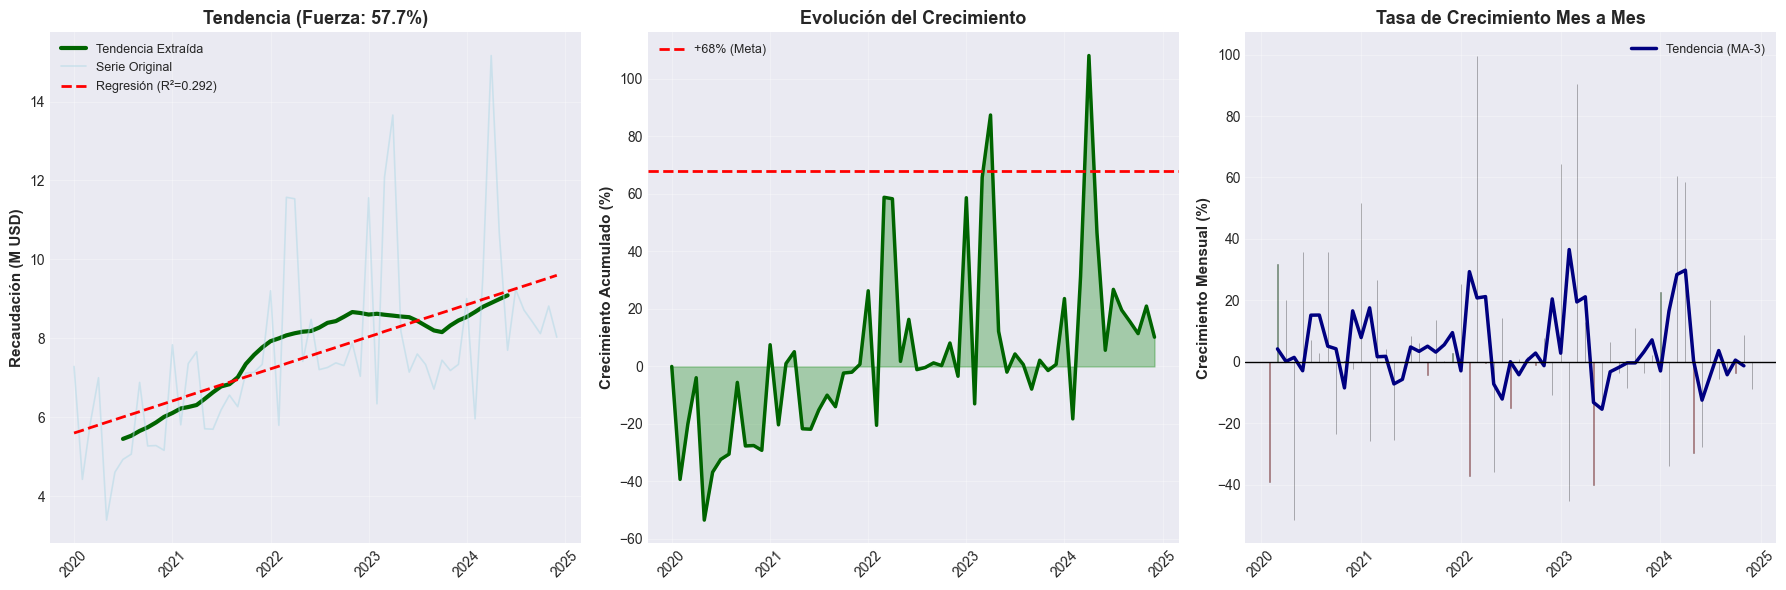


Fig. 7 - Componente de Tendencia del Modelo (β - Beta)

Interpretación: El componente de tendencia muestra una fuerza del 57.7%, 
con ajuste lineal que explica el 29.2% de la variabilidad (R²=0.292). 
La pendiente de +$0.068M por mes confirma crecimiento sostenido, alcanzando el 68.0% 
acumulado en 5 años. Se observa desaceleración reciente: de +23.9% (2021) y +21.6% (2022) 
a +4.6% (2023) y +6.7% (2024). El parámetro β=0.0000 
refleja ajuste conservador de la tendencia proyectada.



In [19]:
# BLOQUE 12: Fig. 7 - Componente de Tendencia
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Panel 1: Tendencia vs Serie Original
axes[0].plot(decomposition.trend.index, decomposition.trend.values/1e6, 
             color='darkgreen', linewidth=3, label='Tendencia Extraída')
axes[0].plot(serie_mensual.index, serie_mensual.values/1e6, 
             color='lightblue', linewidth=1.2, alpha=0.5, label='Serie Original')

# Regresión lineal
x_numeric = np.arange(len(serie_mensual))
slope, intercept, r_value, _, _ = stats.linregress(x_numeric, serie_mensual.values)
linea_regresion = slope * x_numeric + intercept
axes[0].plot(serie_mensual.index, linea_regresion/1e6, 
             color='red', linestyle='--', linewidth=2, label=f'Regresión (R²={r_value**2:.3f})')

axes[0].set_ylabel('Recaudación (M USD)', fontsize=11, fontweight='bold')
axes[0].set_title(f'Tendencia (Fuerza: {tendencia_strength*100:.1f}%)', 
                  fontsize=13, fontweight='bold')
axes[0].legend(fontsize=9, loc='upper left')
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Panel 2: Crecimiento acumulado
crecimiento_acum = ((serie_mensual / serie_mensual.iloc[0]) - 1) * 100
axes[1].fill_between(crecimiento_acum.index, 0, crecimiento_acum.values, 
                      color='green', alpha=0.3)
axes[1].plot(crecimiento_acum.index, crecimiento_acum.values, 
             color='darkgreen', linewidth=2.5)
axes[1].axhline(68, color='red', linestyle='--', linewidth=2, label='+68% (Meta)')
axes[1].set_ylabel('Crecimiento Acumulado (%)', fontsize=11, fontweight='bold')
axes[1].set_title('Evolución del Crecimiento', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=9, loc='upper left')
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

# Panel 3: Tasa mensual
crec_mensual = serie_mensual.pct_change() * 100
crec_suavizado = crec_mensual.rolling(window=3, center=True).mean()

axes[2].bar(crec_mensual.index, crec_mensual.values, 
            color=['green' if x > 0 else 'red' for x in crec_mensual.values],
            alpha=0.4, edgecolor='black', linewidth=0.5)
axes[2].plot(crec_suavizado.index, crec_suavizado.values, 
             color='navy', linewidth=2.5, label='Tendencia (MA-3)')
axes[2].axhline(0, color='black', linestyle='-', linewidth=1)
axes[2].set_ylabel('Crecimiento Mensual (%)', fontsize=11, fontweight='bold')
axes[2].set_title('Tasa de Crecimiento Mes a Mes', fontsize=13, fontweight='bold')
axes[2].legend(fontsize=9, loc='upper right')
axes[2].grid(True, alpha=0.3)
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('Fig_7_Componente_Tendencia.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("Fig. 7 - Componente de Tendencia del Modelo (β - Beta)")
print("="*80)
print(f"""
Interpretación: El componente de tendencia muestra una fuerza del {tendencia_strength*100:.1f}%, 
con ajuste lineal que explica el {r_value**2*100:.1f}% de la variabilidad (R²={r_value**2:.3f}). 
La pendiente de +${slope/1e6:.3f}M por mes confirma crecimiento sostenido, alcanzando el {crec_total:.1f}% 
acumulado en 5 años. Se observa desaceleración reciente: de +23.9% (2021) y +21.6% (2022) 
a +4.6% (2023) y +6.7% (2024). El parámetro β={modelo_final_fit.params['smoothing_trend']:.4f} 
refleja ajuste conservador de la tendencia proyectada.
""")